In [1]:
import os
os.chdir("../")

In [2]:
import collections
import json
from pathlib import Path
from types import SimpleNamespace

import click
import numpy as np
import pandas as pd

In [3]:
results_jsonl = "outputs/temp_0.5-n_64-top_p_0.95/v0/Qwen2.5-VL-3B-Instruct/eval_results.jsonl"

is_correct_matrix = []
with open(results_jsonl, "r") as f:
    for line in f:
        data = json.loads(line)
        is_correct_list = []
        for i in data["parsed_outputs"]:
            is_correct_list.append(i["is_correct"])
        is_correct_matrix.append(is_correct_list)
is_correct_matrix = np.array(is_correct_matrix)

In [4]:
data.keys()

dict_keys(['dp_index', 'prompts', 'dataset_name', 'dataset_index', 'answer_label', 'answer', 'parsed_outputs', 'num_rollouts', 'num_correct'])

In [5]:
from math import comb
def pass_at_k(is_correct: np.ndarray, k: int) -> float:
    """
    Compute pass@k for a batch of questions.

    Parameters
    ----------
    is_correct : np.ndarray, bool, shape = (num_questions, num_rollouts)
        Boolean matrix where ``is_correct[i, j]`` is True iff
        rollout *j* solves question *i*.
    k : int
        Number of solutions you will sample *without replacement*
        for each question when estimating pass@k.

    Returns
    -------
    float
        The average probability that at least one of the ``k`` sampled
        solutions is correct (i.e. the standard “pass@k” metric used in
        CodeX, HumanEval, etc.).
    """
    if not np.issubdtype(is_correct.dtype, np.bool_):
        raise TypeError("`is_correct` must be a boolean array")

    Q, n = is_correct.shape                     # questions, roll-outs
    if not (1 <= k <= n):
        raise ValueError(f"k must be in [1, {n}]")

    probs = np.empty(Q, dtype=np.float64)

    for q in range(Q):
        c = int(is_correct[q].sum())            # correct roll-outs for q-th question

        if c == 0:                              # never solved → guaranteed failure
            probs[q] = 0.0
        elif k > n - c:                         # draw more than #wrong ⇒ always succeed
            probs[q] = 1.0
        else:                                   # standard hyper-geometric success prob.
            probs[q] = 1.0 - comb(n - c, k) / comb(n, k)

    return float(probs.mean())

def pass_at_ks(is_correct: np.ndarray, ks) -> dict[int, float]:
    """
    Convenience wrapper: compute pass@k for many k values at once.

    Example
    -------
    >>> res = pass_at_ks(is_correct, [1, 5, 10])
    >>> print(res)          # {1: 0.312, 5: 0.546, 10: 0.674}
    """
    return {k: pass_at_k(is_correct, k) for k in ks}

In [6]:
pass_at_ks_matrix = pass_at_ks(is_correct_matrix, [1,2,4,8,16,32,64])

In [7]:
results_dir = "outputs/temp_0.5-n_64-top_p_0.95"
results_jsonl_list = list(Path(results_dir).glob("**/eval_results.jsonl"))

In [8]:
results_jsonl_list

[PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_3b-pmc_vqa-m23k_rl-step_1805/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/Qwen2.5-VL-7B-Instruct/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_3b-m23k-step_320/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_3b-pmc_vqa-step_451/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_7b-pmc_vqa-step_451/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/Qwen2.5-VL-3B-Instruct/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_7b-pmc_vqa-m23k_rl-step_1805/eval_results.jsonl'),
 PosixPath('outputs/temp_0.5-n_64-top_p_0.95/v0/train-qwen2_5_vl_7b-m23k-step_320/eval_results.jsonl')]

In [9]:
results_jsonl_list = [i for i in results_jsonl_list if "pmc_vqa-m23k_rl-step_1805" not in str(i)]

In [10]:
# model_name -> dataset_name -> is_correct_matrix
md2ds2is_correct_matrix = dict()
for results_jsonl in results_jsonl_list:
    model_name = results_jsonl.parent.name
    print(f"Processing {model_name}...")

    # dataset_name -> is_correct_matrix
    ds2is_correct_matrix = collections.defaultdict(list)
    with open(results_jsonl, "r") as f:
        for line in f:
            data = json.loads(line)
            dataset_name = data["dataset_name"]

            is_correct_list = []
            for i in data["parsed_outputs"]:
                is_correct_list.append(i["is_correct"])
            
            ds2is_correct_matrix[dataset_name].append(is_correct_list)

    is_correct_matrix_all = []
    for dataset_name, is_correct_list in ds2is_correct_matrix.items():
        is_correct_matrix_all.extend(is_correct_list)
    ds2is_correct_matrix["All"] = is_correct_matrix_all

    md2ds2is_correct_matrix[model_name] = ds2is_correct_matrix
    print(f"Done {model_name}.")

Processing Qwen2.5-VL-7B-Instruct...
Done Qwen2.5-VL-7B-Instruct.
Processing train-qwen2_5_vl_3b-m23k-step_320...
Done train-qwen2_5_vl_3b-m23k-step_320.
Processing train-qwen2_5_vl_3b-pmc_vqa-step_451...
Done train-qwen2_5_vl_3b-pmc_vqa-step_451.
Processing train-qwen2_5_vl_7b-pmc_vqa-step_451...
Done train-qwen2_5_vl_7b-pmc_vqa-step_451.
Processing Qwen2.5-VL-3B-Instruct...
Done Qwen2.5-VL-3B-Instruct.
Processing train-qwen2_5_vl_7b-m23k-step_320...
Done train-qwen2_5_vl_7b-m23k-step_320.


In [11]:
dataset_names = next(iter(md2ds2is_correct_matrix.values())).keys()
dataset_names

dict_keys(['pmc_vqa', 'MMMU-medical', 'MedXpertQA-MM', 'pathvqa_closed', 'slake_closed', 'vqa_rad_closed', 'All'])

In [12]:
ds2md2pass_at_ks = collections.defaultdict(dict)
for dataset_name in dataset_names:
    for model_name, ds2is_correct_matrix in md2ds2is_correct_matrix.items():
        print(f"Processing {dataset_name} for {model_name}...")
        is_correct_matrix = np.array(ds2is_correct_matrix[dataset_name])
        pass_at_ks_dict = pass_at_ks(is_correct_matrix, range(1, 65))
        ds2md2pass_at_ks[dataset_name][model_name] = pass_at_ks_dict

Processing pmc_vqa for Qwen2.5-VL-7B-Instruct...


Processing pmc_vqa for train-qwen2_5_vl_3b-m23k-step_320...
Processing pmc_vqa for train-qwen2_5_vl_3b-pmc_vqa-step_451...
Processing pmc_vqa for train-qwen2_5_vl_7b-pmc_vqa-step_451...
Processing pmc_vqa for Qwen2.5-VL-3B-Instruct...
Processing pmc_vqa for train-qwen2_5_vl_7b-m23k-step_320...
Processing MMMU-medical for Qwen2.5-VL-7B-Instruct...
Processing MMMU-medical for train-qwen2_5_vl_3b-m23k-step_320...
Processing MMMU-medical for train-qwen2_5_vl_3b-pmc_vqa-step_451...
Processing MMMU-medical for train-qwen2_5_vl_7b-pmc_vqa-step_451...
Processing MMMU-medical for Qwen2.5-VL-3B-Instruct...
Processing MMMU-medical for train-qwen2_5_vl_7b-m23k-step_320...
Processing MedXpertQA-MM for Qwen2.5-VL-7B-Instruct...
Processing MedXpertQA-MM for train-qwen2_5_vl_3b-m23k-step_320...
Processing MedXpertQA-MM for train-qwen2_5_vl_3b-pmc_vqa-step_451...
Processing MedXpertQA-MM for train-qwen2_5_vl_7b-pmc_vqa-step_451...
Processing MedXpertQA-MM for Qwen2.5-VL-3B-Instruct...
Processing MedXpe

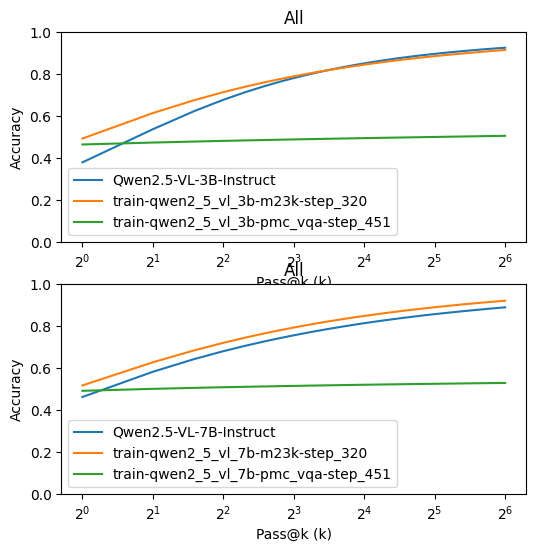

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# for a given dataset, plot pass@k for all models
def plot_pass_at_k(ax, ds2md2pass_at_ks, dataset_name, model_name_contains=None):
    # plot line plot, the x axis is log scale, the base 2
    for model_name in sorted(ds2md2pass_at_ks[dataset_name].keys()):
        if model_name_contains:
            if isinstance(model_name_contains, str):
                if model_name_contains not in model_name:
                    continue
            elif isinstance(model_name_contains, list):
                if not any(m in model_name for m in model_name_contains):
                    continue
            else:
                raise ValueError("model_name_contains must be str or list of str")

        pass_at_ks_dict = ds2md2pass_at_ks[dataset_name][model_name]
        sns.lineplot(
            x=list(pass_at_ks_dict.keys()),
            y=[pass_at_ks_dict[k] for k in pass_at_ks_dict.keys()],
            label=model_name,
            ax=ax
        )

    ax.set_xscale("log", base=2)
    ax.set_xlabel("Pass@k (k)")
    ax.set_ylabel("Accuracy")
    ax.set_title(dataset_name)
    # set y range
    ax.set_ylim(0, 1)

fig, axes = plt.subplots(2, 1, figsize=(6 , 6))
plot_pass_at_k(axes[0], ds2md2pass_at_ks, "All", ["3B", "3b"])
plot_pass_at_k(axes[1], ds2md2pass_at_ks, "All", ["7B", "7b"])

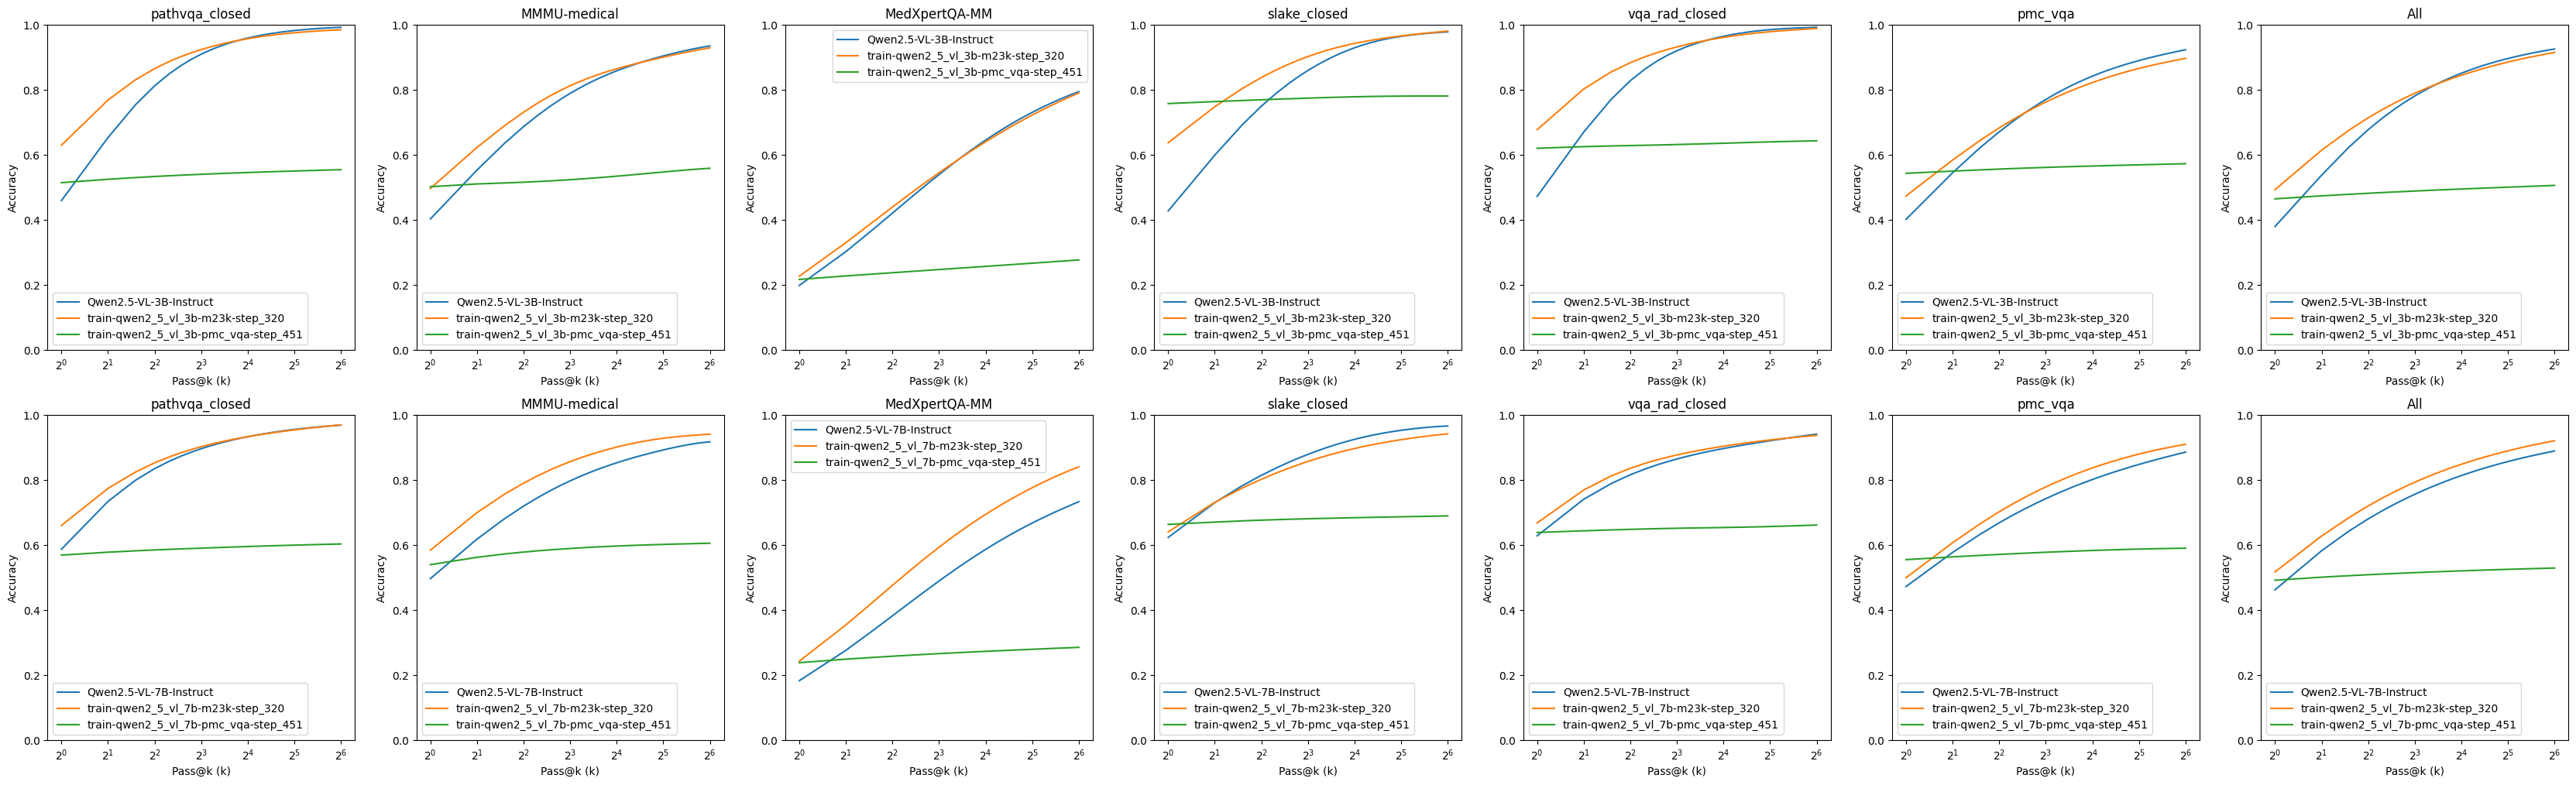

In [14]:
datasets = ['pathvqa_closed', 'MMMU-medical', 'MedXpertQA-MM', 'slake_closed', 'vqa_rad_closed', 'pmc_vqa', 'All']

fig, axes = plt.subplots(2, len(datasets), figsize=(6 * len(datasets), 6 * 2))
for dataset_name, ax in zip(datasets, axes[0]):
    plot_pass_at_k(ax, ds2md2pass_at_ks, dataset_name, ["3B", "3b"])
for dataset_name, ax in zip(datasets, axes[1]):
    plot_pass_at_k(ax, ds2md2pass_at_ks, dataset_name, ["7B", "7b"])